# Siamese Convolutional Neural Network
The main model trained on the datasets.

In [1]:
# own module for preprocessing
from preprocess import PreProcessing
from model import build_model

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import math
import numpy as np

import tensorflow as tf
import keras.backend as K

# model imports
from keras.models import Sequential, Model, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization
from keras.layers import Lambda, concatenate

from keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import cosine_similarity

from keras.callbacks import EarlyStopping


# plotting
from tensorflow.keras.utils import plot_model
import pydotplus as pydot
import matplotlib.pyplot as plt

## Training

In [2]:
# paths to datasets
PATHS = ["data\\CEDAR",
         "data\\BHSig260-Bengali",
         "data\\BHSig260-Hindi"]
# number of classes for each
CLASSES = [55,
           100,
           160]

# size of images
SIZE = 224
INPUT_SHAPE = (SIZE, SIZE, 1)

In [12]:
cedar_data = PreProcessing(PATHS[0])
bh_bengali_data = PreProcessing(PATHS[1])
bh_hindi_data = PreProcessing(PATHS[2])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:23<00:00,  4.44s/it]
C:\Users\ikath\Desktop\GitHub\SignatureVerification\preprocess.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)
100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [09:27<00:00,  3.54s/it]


In [14]:
print("Train images shape      : ", cedar_data.train_images.shape)
print("Validation images shape : ", cedar_data.val_images.shape)

print("\nTrain images shape      : ", bh_bengali_data.train_images.shape)
print("Validation images shape : ", bh_bengali_data.val_images.shape)

print("\nTrain images shape      : ", bh_hindi_data.train_images.shape)
print("Validation images shape : ", bh_hindi_data.val_images.shape)

Train images shape      :  (44, 2, 24, 224, 224, 1)
Validation images shape :  (11, 2, 24, 224, 224, 1)

Train images shape      :  (80, 2)
Validation images shape :  (20, 2)

Train images shape      :  (128, 2)
Validation images shape :  (32, 2)


In [16]:
print('''
                   TRAINING  |  VALIDATION
n_classes        :    {0}     |      {6}
original images  :    {1}     |      {7}
forged images    :    {2}     |      {8}
height           :   {3}     |     {3}
width            :   {4}     |     {4}
channels         :     {5}     |       {5}
'''.format(
    cedar_data.train_images.shape[0],
    len(cedar_data.train_images[0][0]),
    len(cedar_data.train_images[0][1]),
    cedar_data.train_images[0][0][0].shape[0],
    cedar_data.train_images[0][0][0].shape[1],
    cedar_data.train_images[0][0][0].shape[2],
    cedar_data.val_images.shape[0],
    len(cedar_data.val_images[0][0]),
    len(cedar_data.val_images[0][1]),
))


                   TRAINING  |  VALIDATION
n_classes        :    44     |      11
original images  :    24     |      24
forged images    :    24     |      24
height           :   224     |     224
width            :   224     |     224
channels         :     1     |       1



In [17]:
print('''
                   TRAINING  |  VALIDATION
n_classes        :    {0}     |      {6}
original images  :    {1}     |      {7}
forged images    :    {2}     |      {8}
height           :   {3}     |     {3}
width            :   {4}     |     {4}
channels         :     {5}     |       {5}
'''.format(
    bh_bengali_data.train_images.shape[0],
    len(bh_bengali_data.train_images[0][0]),
    len(bh_bengali_data.train_images[0][1]),
    bh_bengali_data.train_images[0][0][0].shape[0],
    bh_bengali_data.train_images[0][0][0].shape[1],
    bh_bengali_data.train_images[0][0][0].shape[2],
    bh_bengali_data.val_images.shape[0],
    len(bh_bengali_data.val_images[0][0]),
    len(bh_bengali_data.val_images[0][1]),
))


                   TRAINING  |  VALIDATION
n_classes        :    80     |      20
original images  :    24     |      24
forged images    :    30     |      30
height           :   224     |     224
width            :   224     |     224
channels         :     1     |       1



In [19]:
print('''
                   TRAINING  |  VALIDATION
n_classes        :   {0}     |      {6}
original images  :    {1}     |      {7}
forged images    :    {2}     |      {8}
height           :   {3}     |     {3}
width            :   {4}     |     {4}
channels         :     {5}     |       {5}
'''.format(
    bh_hindi_data.train_images.shape[0],
    len(bh_hindi_data.train_images[0][0]),
    len(bh_hindi_data.train_images[0][1]),
    bh_hindi_data.train_images[0][0][0].shape[0],
    bh_hindi_data.train_images[0][0][0].shape[1],
    bh_hindi_data.train_images[0][0][0].shape[2],
    bh_hindi_data.val_images.shape[0],
    len(bh_hindi_data.val_images[0][0]),
    len(bh_hindi_data.val_images[0][1]),
))


                   TRAINING  |  VALIDATION
n_classes        :   128     |      32
original images  :    24     |      24
forged images    :    30     |      30
height           :   224     |     224
width            :   224     |     224
channels         :     1     |       1



In [20]:
p, t = cedar_data.get_batches(4)
print("Pairs   : ", len(p))
print("Targets : ", len(t))

p[0].shape, p[1].shape

Pairs   :  2
Targets :  8


((8, 224, 224, 1), (8, 224, 224, 1))

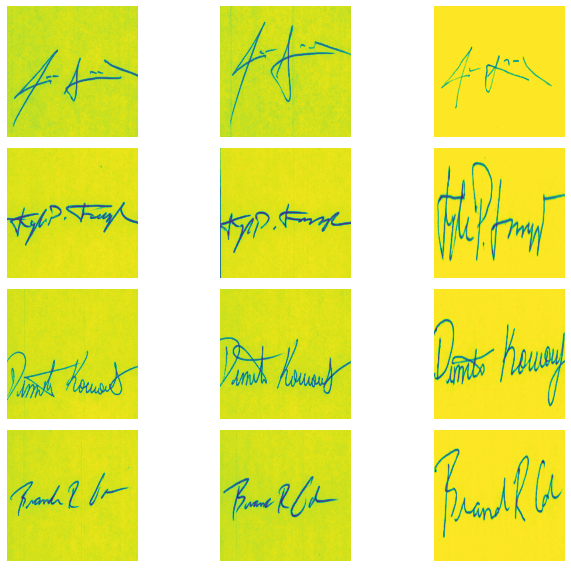

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))
[axi.set_axis_off() for axi in ax.ravel()]
for i,j in zip(range(4), range(0,8,2)):
    ax[i, 0].imshow(p[0][j])
    ax[i, 1].imshow(p[1][j])
    ax[i, 2].imshow(p[1][j+1])
plt.tight_layout()

In [22]:
p, t = bh_bengali_data.get_batches(4)
print("Pairs   : ", len(p))
print("Targets : ", len(t))

p[0].shape, p[1].shape

Pairs   :  2
Targets :  8


((8, 224, 224, 1), (8, 224, 224, 1))

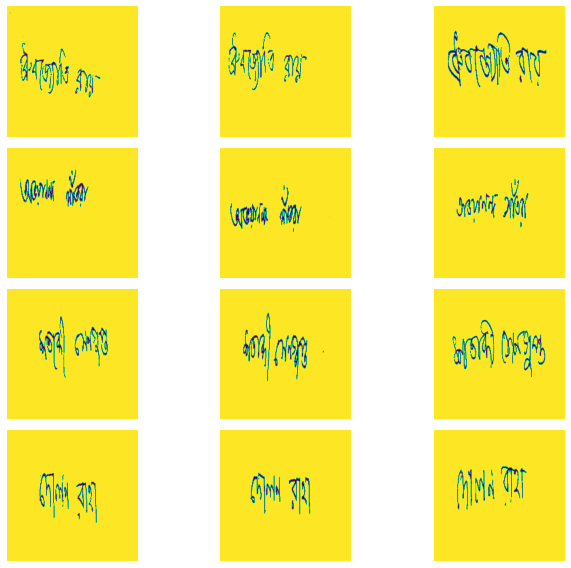

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))
[axi.set_axis_off() for axi in ax.ravel()]
for i,j in zip(range(4), range(0,8,2)):
    ax[i, 0].imshow(p[0][j])
    ax[i, 1].imshow(p[1][j])
    ax[i, 2].imshow(p[1][j+1])
plt.tight_layout()

In [24]:
p, t = bh_hindi_data.get_batches(4)
print("Pairs   : ", len(p))
print("Targets : ", len(t))

p[0].shape, p[1].shape

Pairs   :  2
Targets :  8


((8, 224, 224, 1), (8, 224, 224, 1))

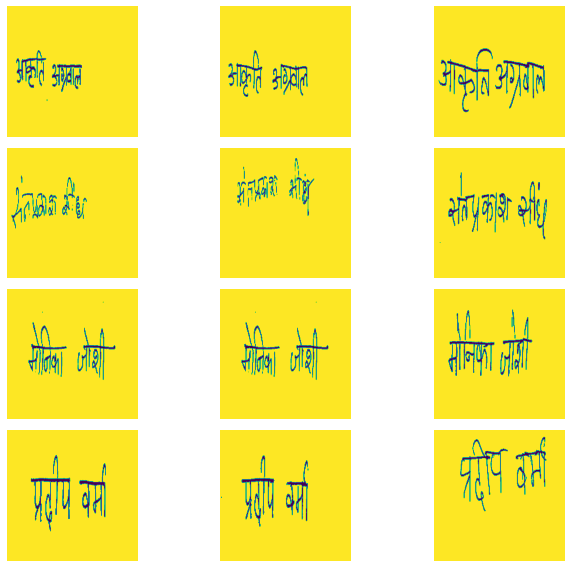

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))
[axi.set_axis_off() for axi in ax.ravel()]
for i,j in zip(range(4), range(0,8,2)):
    ax[i, 0].imshow(p[0][j])
    ax[i, 1].imshow(p[1][j])
    ax[i, 2].imshow(p[1][j+1])
plt.tight_layout()

In [9]:
# hyperparameters
OPT = Adam(lr = 0.00006)

EPOCHS = 100
BS = 2
compute_steps_per_epoch = lambda x: int(math.ceil(x / BS))

# train_steps = compute_steps_per_epoch(44)
# val_steps = compute_steps_per_epoch(11)

train_steps = 51
val_steps = 17

print("Training steps    : ", train_steps)
print("Validation steps  : ", val_steps)

Training steps    :  22
Validation steps  :  6


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 512)          53624128    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           sequential_network[0][0]     

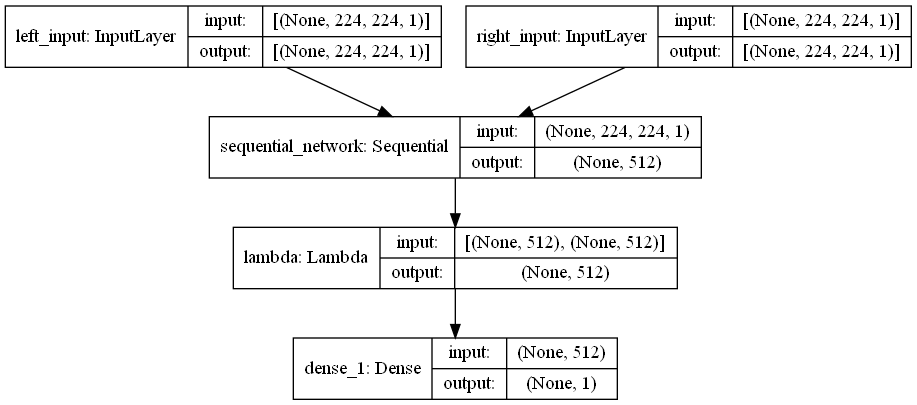

In [10]:
siamese_net = build_model(INPUT_SHAPE)

siamese_net.compile(optimizer=OPT,
                    loss="binary_crossentropy")

siamese_net.summary()
tf.keras.utils.plot_model(
    siamese_net,
    show_shapes=True,
    show_layer_names=True,
    to_file="model_plot.png"
)

In [11]:
---

SyntaxError: invalid syntax (<ipython-input-11-29e0c3615294>, line 1)

In [ ]:
early_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
)

history = siamese_net.fit(
    cedar_data.generate_batch(BS),
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_callback],
    validation_data=cedar_data.generate_batch(BS, False),
    validation_steps=val_steps
)

In [ ]:
siamese_net.save_weights('./weights/siamese_net')

In [ ]:
history.history

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid(True)
plt.show()